In [1]:
# load general libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


# load sklearn 
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

# load keras 
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications.imagenet_utils import decode_predictions


### Feed-forward neural network from scratch

In [2]:
def add_bias(X):
    """
    add bias column to the X
    """
    X = np.hstack([X, np.ones((X.shape[0], 1))])
    return X

In [3]:
def sigmoid(X):
    """
    sigmoid function
    """
    return 1/(1+np.exp(-X))

In [4]:
def feed_forward(X, weights):

    """
    implemention of a feed forward network with a hidden layer and a sigmoid activation function
    """
    step1 = np.dot(X,weights[0])

    output1 = sigmoid(step1)

    step2 = add_bias(output1)

    step3 = np.dot(step2,weights[1])
    
    output2 = sigmoid(step3)
    
    return output1, output2

#### Run the feed fowrward neural network 

In [5]:
# load data
X, y = make_moons(n_samples=50, noise=0.2, random_state=42)

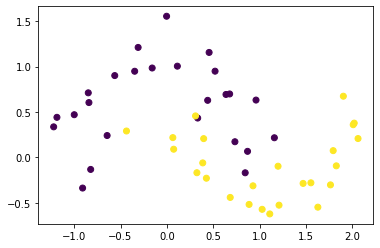

In [6]:
# plot data
plt.scatter(X[:,0],X[:,1],c=y);

In [7]:
# add bias to the X
X = add_bias(X)

In [8]:
# set the weights
W1 = np.random.rand(3,2)
W2 = np.random.rand(3,1)
W = [W1,W2]

In [9]:
# check shape of X and weights
X.shape, W1.shape, W2.shape

((50, 3), (3, 2), (3, 1))

In [10]:
# run the feed forward network and check shape of outputs
out1, out2 = feed_forward(X, W)
assert out1.shape == (50, 2)
assert out2.shape == (50, 1)

In [11]:
# run the feed forward network with other parameters
Xref = np.array([[1.0, 2.0, 1.0]])
whidden = np.array([[1.0, 2.0, 0.0],
                 [-1.0, -2.0, 0.0]
                    ]).T
wout = np.array([[1.0, -1.0, 0.5]]).T

out1, out2 = feed_forward(Xref, [whidden, wout])
assert np.all(out1.round(2) == np.array([[0.99, 0.01]]))
assert np.all(out2.round(2) == np.array([[0.82]]))

### Backpropagation from Scratch

In [12]:
def sigmoid_deriv(X):
    """
    derivative of sigmoid with respect to X
    """
    return sigmoid(X) * (1-sigmoid(X))

In [13]:
def log_loss(ytrue, ypred):
    """
    log loss function
    """
    loss = -((ytrue * np.log(ypred)) + ((1 - ytrue) * np.log(1-ypred)))
    return loss

In [14]:
def log_loss_deriv(ytrue, ypred):
    """
    derivative of log loss function
    """
    loss_deriv = -(((ytrue / ypred)) - ((1-ytrue)/(1-ypred)))
    return loss_deriv

In [15]:
def backprop(weights,output1,output2,ytrue,X_input,LR):
    """
    implementation of the backpropagation algorithm
    """

    wH = weights[0]
    wO = weights[1]


    loss_gradient = log_loss_deriv(ytrue , output2)

    hidden_out_with_bias = add_bias(output1)

    sig_deriv_1 = sigmoid_deriv(np.dot(hidden_out_with_bias,wO))
    y_grad = sig_deriv_1 * loss_gradient

    delta_wo = -np.dot( y_grad.T, hidden_out_with_bias ) * LR

    wO_new = wO + delta_wo.T

    sig_deriv_2 = sigmoid_deriv(output1)

    H_grad = sig_deriv_2 * np.dot(y_grad , wO[:-1].T)

    delta_wH = -np.dot(H_grad.T,X_input ) * LR


    wH_new = wH + delta_wH.T

    return wH_new, wO_new

#### Run the Backpropagation algorithm

In [16]:
# setup
X, y = make_moons(n_samples=200, noise=0.1, random_state=42)
X = add_bias(X)
y = y.reshape(-1, 1)
weights = [
   np.random.normal(size=(3, 2)),
   np.random.normal(size=(3, 1))
]

In [17]:
# train
LOSS_VEC = []

for i in range(1000):
    out1, out2 = feed_forward(X, weights)
    LOSS_VEC.append(log_loss(y, out2).sum())
    new_weights = backprop(weights, out1, out2, y, X, LR= 0.001)
    weights = new_weights

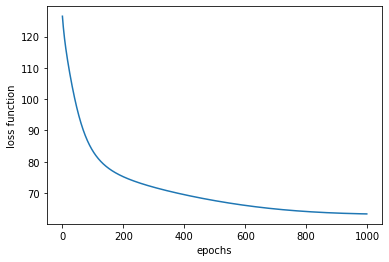

In [18]:
# plot learning curve
plt.plot(LOSS_VEC)
plt.xlabel('epochs')
plt.ylabel('loss function');

### Build and train a FFNN using MNIST dataset in Keras

#### Data preprocessing

In [19]:
# load data
(Xtrain, ytrain), (Xtest, ytest) = mnist.load_data()

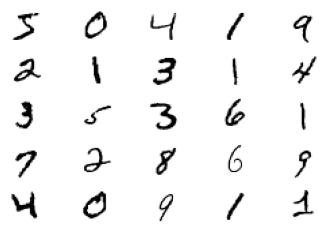

In [20]:
# plot some of the digits
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(Xtrain[i], cmap=plt.cm.Greys)
    plt.axis('off')

In [21]:
# reshape the training images to vectors
Xtrain_reshaped = Xtrain.reshape(60000,-1)
# or  Xtrain.reshape(60000,28*28)

In [22]:
# one-hot-encode the ytrain 
ytrain_encoded = to_categorical(ytrain)
ytrain_encoded.shape

(60000, 10)

#### Build and train the FFNN

In [23]:
# clear Keras backend session
K.clear_session()
# build model
model = Sequential([
    # first layer
    Dense(units=40, activation='relu',input_shape=(28*28,)),
    # batch normalization
    BatchNormalization(),
    
    #hidden layer(s)
    Dense(units=60,activation='relu'),
    # batch normalization
    BatchNormalization(),
    
    # dropout
    Dropout(0.5),
    
    #output layer
    Dense(units=10,activation='softmax')
])

In [24]:
# compile the model
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 40)                31400     
_________________________________________________________________
batch_normalization (BatchNo (None, 40)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 60)                2460      
_________________________________________________________________
batch_normalization_1 (Batch (None, 60)                240       
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                610       
Total params: 34,870
Trainable params: 34,670
Non-trainable params: 200
__________________________________________________

In [26]:
# Early stopping:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', #the thing we are monitoring
    min_delta=0.0005, #the minimum change in the quantity that we want for the model to train for another epoch
    patience=3, #number of epochs with no improvement needed for the model to stop
    verbose=1, #0 is silent, 1 means a message is displayed when something happens
    mode='auto'  
)

In [27]:
# fit the model
history = model.fit(Xtrain_reshaped,ytrain_encoded, epochs = 100, batch_size = 100, validation_split = 0.2, verbose = 1, callbacks = [early_stop])

Epoch 1/100
480/480 [==============================] - 2s 3ms/step - loss: 0.6507 - accuracy: 0.8035 - val_loss: 0.2390 - val_accuracy: 0.9277
Epoch 2/100
480/480 [==============================] - 1s 2ms/step - loss: 0.2888 - accuracy: 0.9159 - val_loss: 0.1709 - val_accuracy: 0.9498
Epoch 3/100
480/480 [==============================] - 1s 2ms/step - loss: 0.2215 - accuracy: 0.9367 - val_loss: 0.1440 - val_accuracy: 0.9567
Epoch 4/100
480/480 [==============================] - 1s 2ms/step - loss: 0.1849 - accuracy: 0.9474 - val_loss: 0.1322 - val_accuracy: 0.9610
Epoch 5/100
480/480 [==============================] - 1s 2ms/step - loss: 0.1584 - accuracy: 0.9529 - val_loss: 0.1308 - val_accuracy: 0.9612
Epoch 6/100
480/480 [==============================] - 1s 2ms/step - loss: 0.1417 - accuracy: 0.9578 - val_loss: 0.1195 - val_accuracy: 0.9662
Epoch 7/100
480/480 [==============================] - 1s 2ms/step - loss: 0.1304 - accuracy: 0.9604 - val_loss: 0.1168 - val_accuracy: 0.9668

#### Evaluate the trained FNN

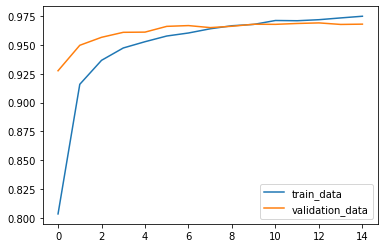

In [28]:
# plot learning curve
plt.plot(history.history['accuracy'], label = 'train_data')
plt.plot(history.history['val_accuracy'], label = 'validation_data')
plt.legend()

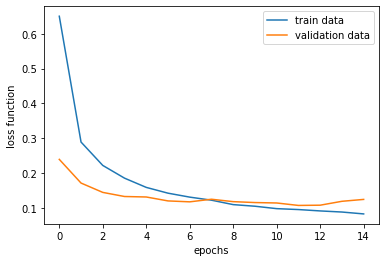

In [29]:
plt.plot(history.history['loss'], label = 'train data')
plt.plot(history.history['val_loss'], label = 'validation data')
plt.xlabel('epochs')
plt.ylabel('loss function');
plt.legend()

### Build and train a CNN using personal prepared image dataset in Keras

In [30]:
def image_preparer(base_path,classes):
    """
    get the base path and classes of images and return the images and related label in numpy array X nad y  
    """
    X = []
    y = []
    for i, target in enumerate(classes):

        files = os.listdir(base_path+target)
        for file in files:
            if file == '.DS_Store':
                continue
            # load the image
            img = plt.imread(base_path+target+'/'+file)
            # append the array to X
            X.append(img)
            # append the numeric target to y
            y.append(i)
            # convert X and y into numpy array
    X = np.array(X)
    y = np.array(y)
    return X,y

In [31]:
def show_img_label(X,y,classes,pred):
    """
    show 25 of the images with their labels
    """
    plt.figure(figsize = (10,8))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(X[i])
        plt.axis('off')
        if pred == False:
            plt.text(60, -10, classes[y[i]])
        if pred == True:
            plt.text(60, -10, classes[np.argmax(y[i])])

#### Data preprocessing

In [32]:
# load data
classes = ['tomato','apple','pen','highlighter']
base_path = '../data/'
X,y = image_preparer(base_path,classes)

In [33]:
# check shape of data
X.shape,y.shape

((434, 224, 224, 3), (434,))

In [34]:
# shuffle the data
shuffler = np.random.permutation(len(X))
X = X[shuffler]
y = y[shuffler]

In [35]:
# train test split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)

In [36]:
# apply one-hot encoder on y
ytrain_encoded = to_categorical(ytrain)
ytest_encoded = to_categorical(ytest)

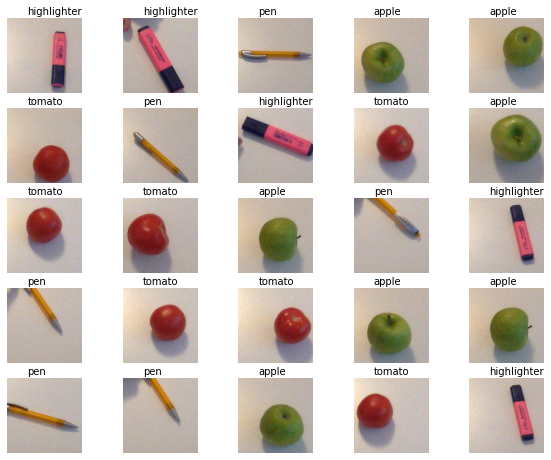

In [37]:
# Have a look at the data
show_img_label(Xtrain,ytrain,classes,pred=False)

#### Build and train the CNN

In [38]:
# Clear session and build model
K.clear_session()

model = Sequential([
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = "valid", activation = "relu" ,input_shape = (224,224,3)),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = "valid"),

    
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = "valid", activation = "relu"),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = "valid"),
    
    Flatten(),
    
    #Fully connected layers
    
    Dense(100,activation='relu'),
    Dropout(0.2),# - optional
    
    #Output layer:
    Dense(4 ,activation= "softmax")

    
])

In [39]:
# Check the summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 46656)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               4665700   
_________________________________________________________________
dropout (Dropout)            (None, 100)               0

In [40]:
# Compile the model
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [41]:
# Early stopping
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', #the thing we are monitoring
    min_delta=0.001, #the minimum change in the quantity that we want for the model to train for another epoch
    patience=3, #number of epochs with no improvement needed for the model to stop
    verbose=1, #0 is silent, 1 means a message is displayed when something happens
    mode='auto'  
)

In [42]:
# Fit the model
history = model.fit(Xtrain,ytrain_encoded,batch_size=50, epochs=15,validation_split=0.2,callbacks=early_stop)

Epoch 1/15
6/6 [==============================] - 7s 898ms/step - loss: 2.7772 - accuracy: 0.3357 - val_loss: 2.0956 - val_accuracy: 0.2143
Epoch 2/15
6/6 [==============================] - 5s 747ms/step - loss: 1.5249 - accuracy: 0.3863 - val_loss: 1.1583 - val_accuracy: 0.6714
Epoch 3/15
6/6 [==============================] - 5s 902ms/step - loss: 1.0584 - accuracy: 0.7004 - val_loss: 0.8462 - val_accuracy: 0.8714
Epoch 4/15
6/6 [==============================] - 4s 693ms/step - loss: 0.7194 - accuracy: 0.8628 - val_loss: 0.5138 - val_accuracy: 0.9429
Epoch 5/15
6/6 [==============================] - 6s 897ms/step - loss: 0.4384 - accuracy: 0.8989 - val_loss: 0.3080 - val_accuracy: 0.9286
Epoch 6/15
6/6 [==============================] - 5s 838ms/step - loss: 0.2799 - accuracy: 0.9206 - val_loss: 0.1642 - val_accuracy: 0.9429
Epoch 7/15
6/6 [==============================] - 5s 905ms/step - loss: 0.1715 - accuracy: 0.9639 - val_loss: 0.0871 - val_accuracy: 0.9714
Epoch 8/15
6/6 [====

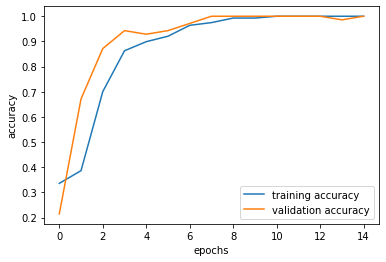

In [43]:
# plot learning curve
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label= 'validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend();

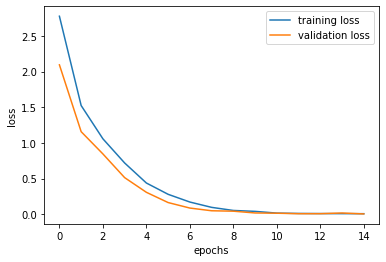

In [44]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend();

#### Make prediction using trained CNN

In [45]:
ypred = model.predict(Xtest)

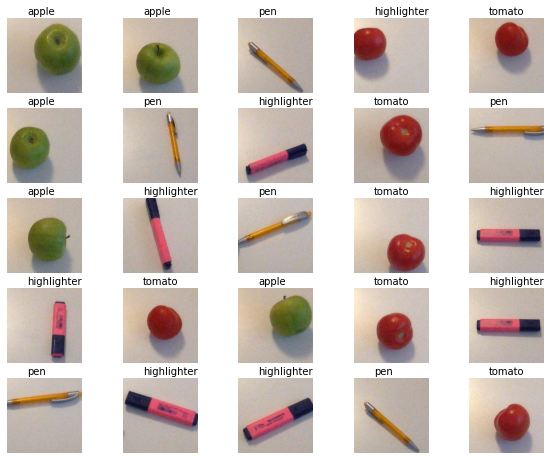

In [46]:
# function should be modified
show_img_label(Xtest,ypred,classes,pred=True)

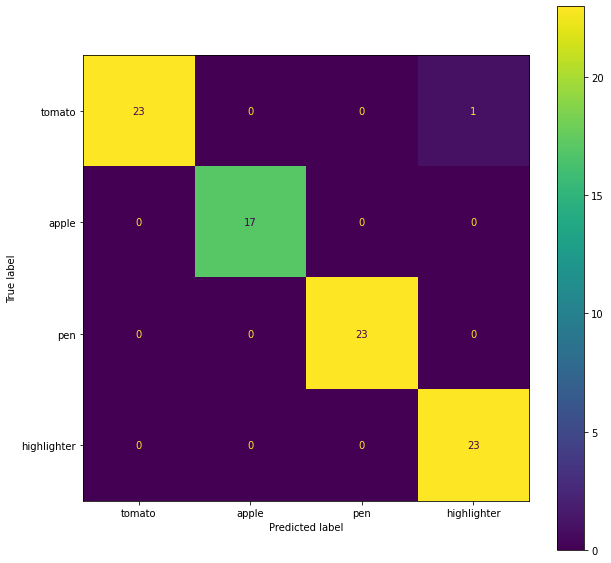

In [47]:
# plot confusion matrix
cm = confusion_matrix(y_true=ytest, y_pred=np.argmax(ypred, axis=1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=classes)
fig, ax = plt.subplots(figsize=(10,10))

disp.plot(ax=ax);

In [48]:
# save the model
model.save('../models/4clasess_object_recognizer_model.h5')

### Use a pretrained CNN to make prediction on personal prepared image dataset

#### Data preprocessing

In [49]:
Xtrain = mobilenet_v2.preprocess_input(Xtrain)
Xtest = mobilenet_v2.preprocess_input(Xtest)

In [50]:
classes = ['tomato','apple','pen','highlighter','empty']
base_path = '../data/'

In [51]:
# define an image data generator
data_gen = ImageDataGenerator(preprocessing_function=mobilenet_v2.preprocess_input)

In [52]:
# a generator that returns batches of X and y arrays
train_data_gen = data_gen.flow_from_directory(
        directory=base_path,
        class_mode="categorical",
        classes=classes,
        batch_size=400,
        target_size=(224, 224)
)

Found 602 images belonging to 5 classes.


In [53]:
# load in all images at once
xtrain, ytrain = next(train_data_gen)
xtrain.shape, ytrain.shape

((400, 224, 224, 3), (400, 5))

#### Create CNN

In [54]:
# select the convolutional base
K.clear_session()
base_model = mobilenet_v2.MobileNetV2(weights='imagenet',include_top=False,pooling='avg',alpha=0.35,input_shape=(224,224,3))

In [55]:
base_model.summary()

Model: "mobilenetv2_0.35_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 16) 432         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 16) 64          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 16) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [56]:
# freeze the weights
base_model.trainable = False

In [57]:
base_model.summary()

Model: "mobilenetv2_0.35_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 16) 432         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 16) 64          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 16) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [58]:
# add the dense layers on top
model = Sequential()
model.add(base_model)
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes),activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_0.35_224 (Functi (None, 1280)              410208    
_________________________________________________________________
dense (Dense)                (None, 100)               128100    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 538,813
Trainable params: 128,605
Non-trainable params: 410,208
_________________________________________________________________


#### Compile and train CNN

In [59]:

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,min_delta=0.001)


history = model.fit(xtrain, ytrain, 
          epochs=50, 
          verbose=1,
          batch_size=100, 
          callbacks=[callback],
          validation_split=0.3)

Epoch 1/50
3/3 [==============================] - 8s 2s/step - loss: 1.3620 - accuracy: 0.4786 - val_loss: 0.2872 - val_accuracy: 1.0000
Epoch 2/50
3/3 [==============================] - 4s 1s/step - loss: 0.3047 - accuracy: 0.9393 - val_loss: 0.0622 - val_accuracy: 1.0000
Epoch 3/50
3/3 [==============================] - 3s 1s/step - loss: 0.0959 - accuracy: 0.9821 - val_loss: 0.0217 - val_accuracy: 1.0000
Epoch 4/50
3/3 [==============================] - 3s 1s/step - loss: 0.0398 - accuracy: 0.9929 - val_loss: 0.0117 - val_accuracy: 1.0000
Epoch 5/50
3/3 [==============================] - 4s 1s/step - loss: 0.0201 - accuracy: 0.9964 - val_loss: 0.0072 - val_accuracy: 1.0000
Epoch 6/50
3/3 [==============================] - 3s 1s/step - loss: 0.0176 - accuracy: 1.0000 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 7/50
3/3 [==============================] - 4s 1s/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 8/50
3/3 [=========================

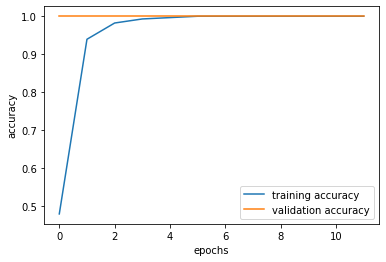

In [60]:
# plot learning curve
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label= 'validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend();

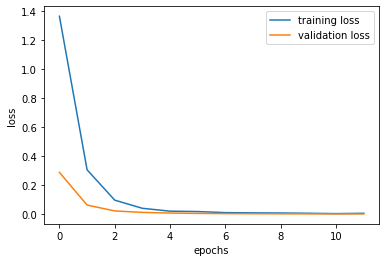

In [61]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend();

In [62]:
# save the model
model.save('../models/4clasess_object_recognizer_pretrained_model.h5')

/Users/admin/opt/anaconda3/envs/deep_learning/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
